# Прогнозирование конечных свойств новых материалов (композиционных материалов)
Композиционные материалы - это искусственно созданные материалы, состоящие из нескольких других с четкой границей между ними. Композиты обладают теми свойствами, которые не наблюдаются у компонентов по отдельности. При этом композиты являются монолитным материалом, т. е. компоненты материала неотделимы друг от друга без разрушения конструкции в целом. Яркий пример композита - железобетон. Бетон прекрасно сопротивляется сжатию, но плохо растяжению. Стальная арматура внутри бетона компенсирует его неспособность сопротивляться сжатию, формируя тем самым новые, уникальные свойства. Современные композиты изготавливаются из других материалов: полимеры, керамика, стеклянные и углеродные волокна, но данный принцип сохраняется. У такого подхода есть и недостаток: даже если мы знаем характеристики исходных компонентов, определить характеристики композита, состоящего из этих компонентов, достаточно проблематично. Для решения этой проблемы есть два пути: физические испытания образцов материалов, или прогнозирование характеристик. Суть прогнозирования заключается в симуляции представительного элемента объема композита, на основе данных о характеристиках входящих компонентов (связующего и армирующего компонента)

## Импорты

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import scipy.stats as stats

## Загрузить и объединить датасет

### Загрузка данных

In [5]:
X_bp = pd.read_excel(
    'https://github.com/ritulupov/BKP/blob/main/data/X_bp.xlsx?raw=true',
     index_col=0, engine='openpyxl')

X_nup = pd.read_excel(
    'https://github.com/ritulupov/BKP/blob/main/data/X_nup.xlsx?raw=true',
     index_col=0, engine='openpyxl')

In [6]:
X_bp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
dtypes: float64(10)
memory usage: 87.9 KB


Есть 10 колонок тип данных float64. Строк 1024, пропусков нет.

In [7]:
X_nup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 0 to 1039
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Угол нашивки, град  1040 non-null   int64  
 1   Шаг нашивки         1040 non-null   float64
 2   Плотность нашивки   1040 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 32.5 KB


Есть 3 колонки. 1 - int, 2 - float64. Строк 1040, пропусков нет.

### Объединение по индексу тип объединения INNER

In [8]:
full_df = X_bp.join(X_nup)

In [9]:
full_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,1023.0,2.930366,0.913222,0.389403,2.317887,2.906878,3.552660,5.591742
"Плотность, кг/м3",1023.0,1975.734888,73.729231,1731.764635,1924.155467,1977.621657,2021.374375,2207.773481
"модуль упругости, ГПа",1023.0,739.923233,330.231581,2.436909,500.047452,739.664328,961.812526,1911.536477
"Количество отвердителя, м.%",1023.0,110.570769,28.295911,17.740275,92.443497,110.564840,129.730366,198.953207
"Содержание эпоксидных групп,%_2",1023.0,22.244390,2.406301,14.254985,20.608034,22.230744,23.961934,33.000000
"Температура вспышки, С_2",1023.0,285.882151,40.943260,100.000000,259.066528,285.896812,313.002106,413.273418
"Поверхностная плотность, г/м2",1023.0,482.731833,281.314690,0.603740,266.816645,451.864365,693.225017,1399.542362
"Модуль упругости при растяжении, ГПа",1023.0,73.328571,3.118983,64.054061,71.245018,73.268805,75.356612,82.682051
"Прочность при растяжении, МПа",1023.0,2466.922843,485.628006,1036.856605,2135.850448,2459.524526,2767.193119,3848.436732
"Потребление смолы, г/м2",1023.0,218.423144,59.735931,33.803026,179.627520,219.198882,257.481724,414.590628


In [11]:
drop_cols = ['Плотность, кг/м3',
             'модуль упругости, ГПа',
             'Поверхностная плотность, г/м2'
             ]
targ_cols = ['Модуль упругости при растяжении,ГПа',
             'Прочность при растяжении, МПа',
             'Соотношение матрица-наполнитель'
             ]

Поверхностная плотность, г/м2: **93.605670**

1)	Изучить теоретические основы и методы решения поставленной задачи.
2)	Провести разведочный анализ предложенных данных. Необходимо нарисовать гистограммы распределения каждой из переменной, диаграммы ящика с усами, попарные графики рассеяния точек. Необходимо также для каждой колонке получить среднее, медианное значение, провести анализ и исключение выбросов, проверить наличие пропусков.
3)	Провести предобработку данных (удаление шумов, нормализация и т.д.).
4)	Обучить нескольких моделей для прогноза модуля упругости при растяжении и прочности при растяжении. При построении модели необходимо 30% данных оставить на тестирование модели, на остальных происходит обучение моделей. При построении моделей провести поиск гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10.
5)	Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель. 
6)	Разработать приложение с графическим интерфейсом или интерфейсом командной строки, которое будет выдавать прогноз, полученный в задании 4 или 5 (один или два прогноза, на выбор учащегося).
7)	Оценить точность модели на тренировочном и тестовом датасете. 
8)	Создать репозиторий в GitHub / GitLab и разместить там код исследования. Оформить файл README.


## Разведочный анализ

### Тепловая карта корреляций
Никаких сильных корреляций нет.

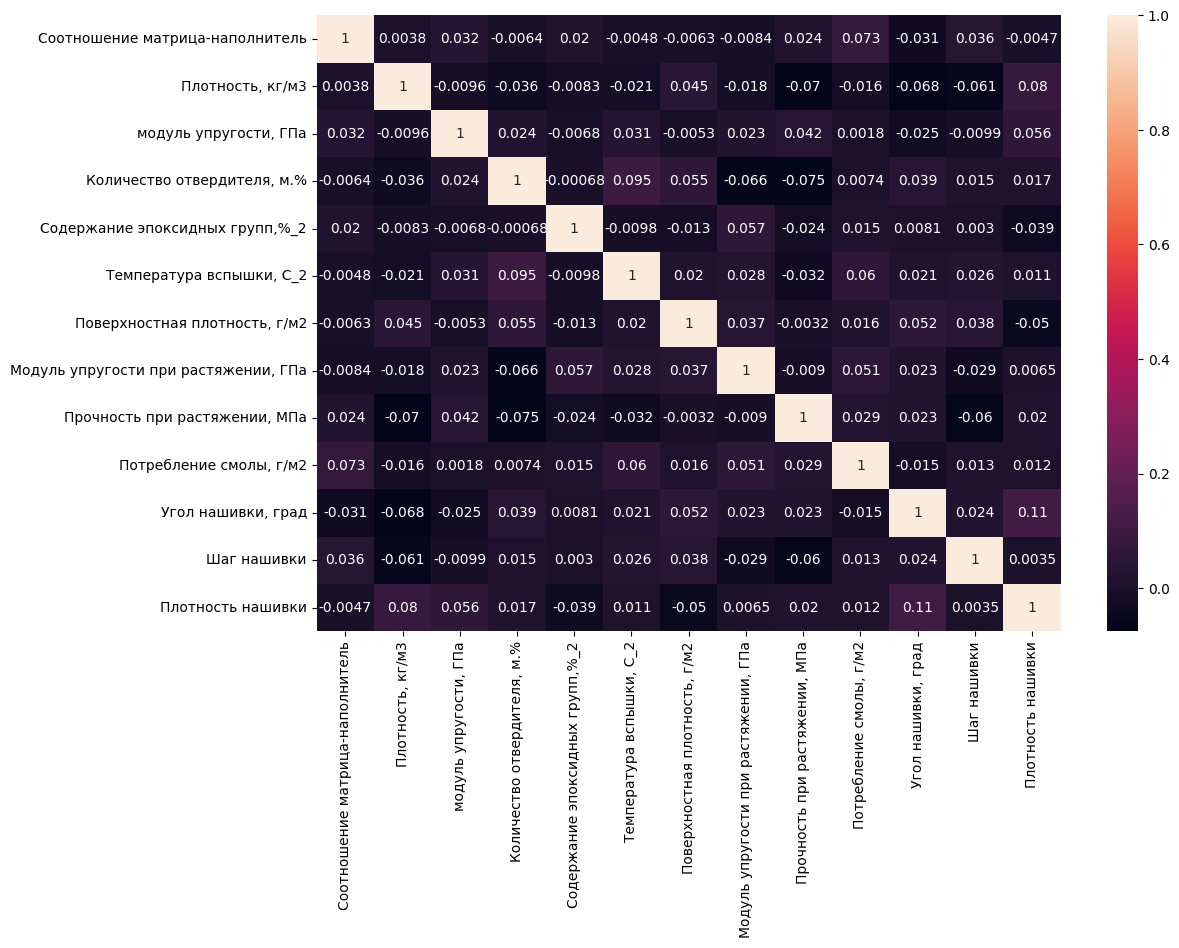

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(full_df.corr(), annot=True, )
plt.show()

### Гистограммы распределения каждой из переменной, диаграммы ящика с усами
график распределения признака 'Поверхностная плотность, г/м2' сдвинут влево, серьезных выбросов нет.

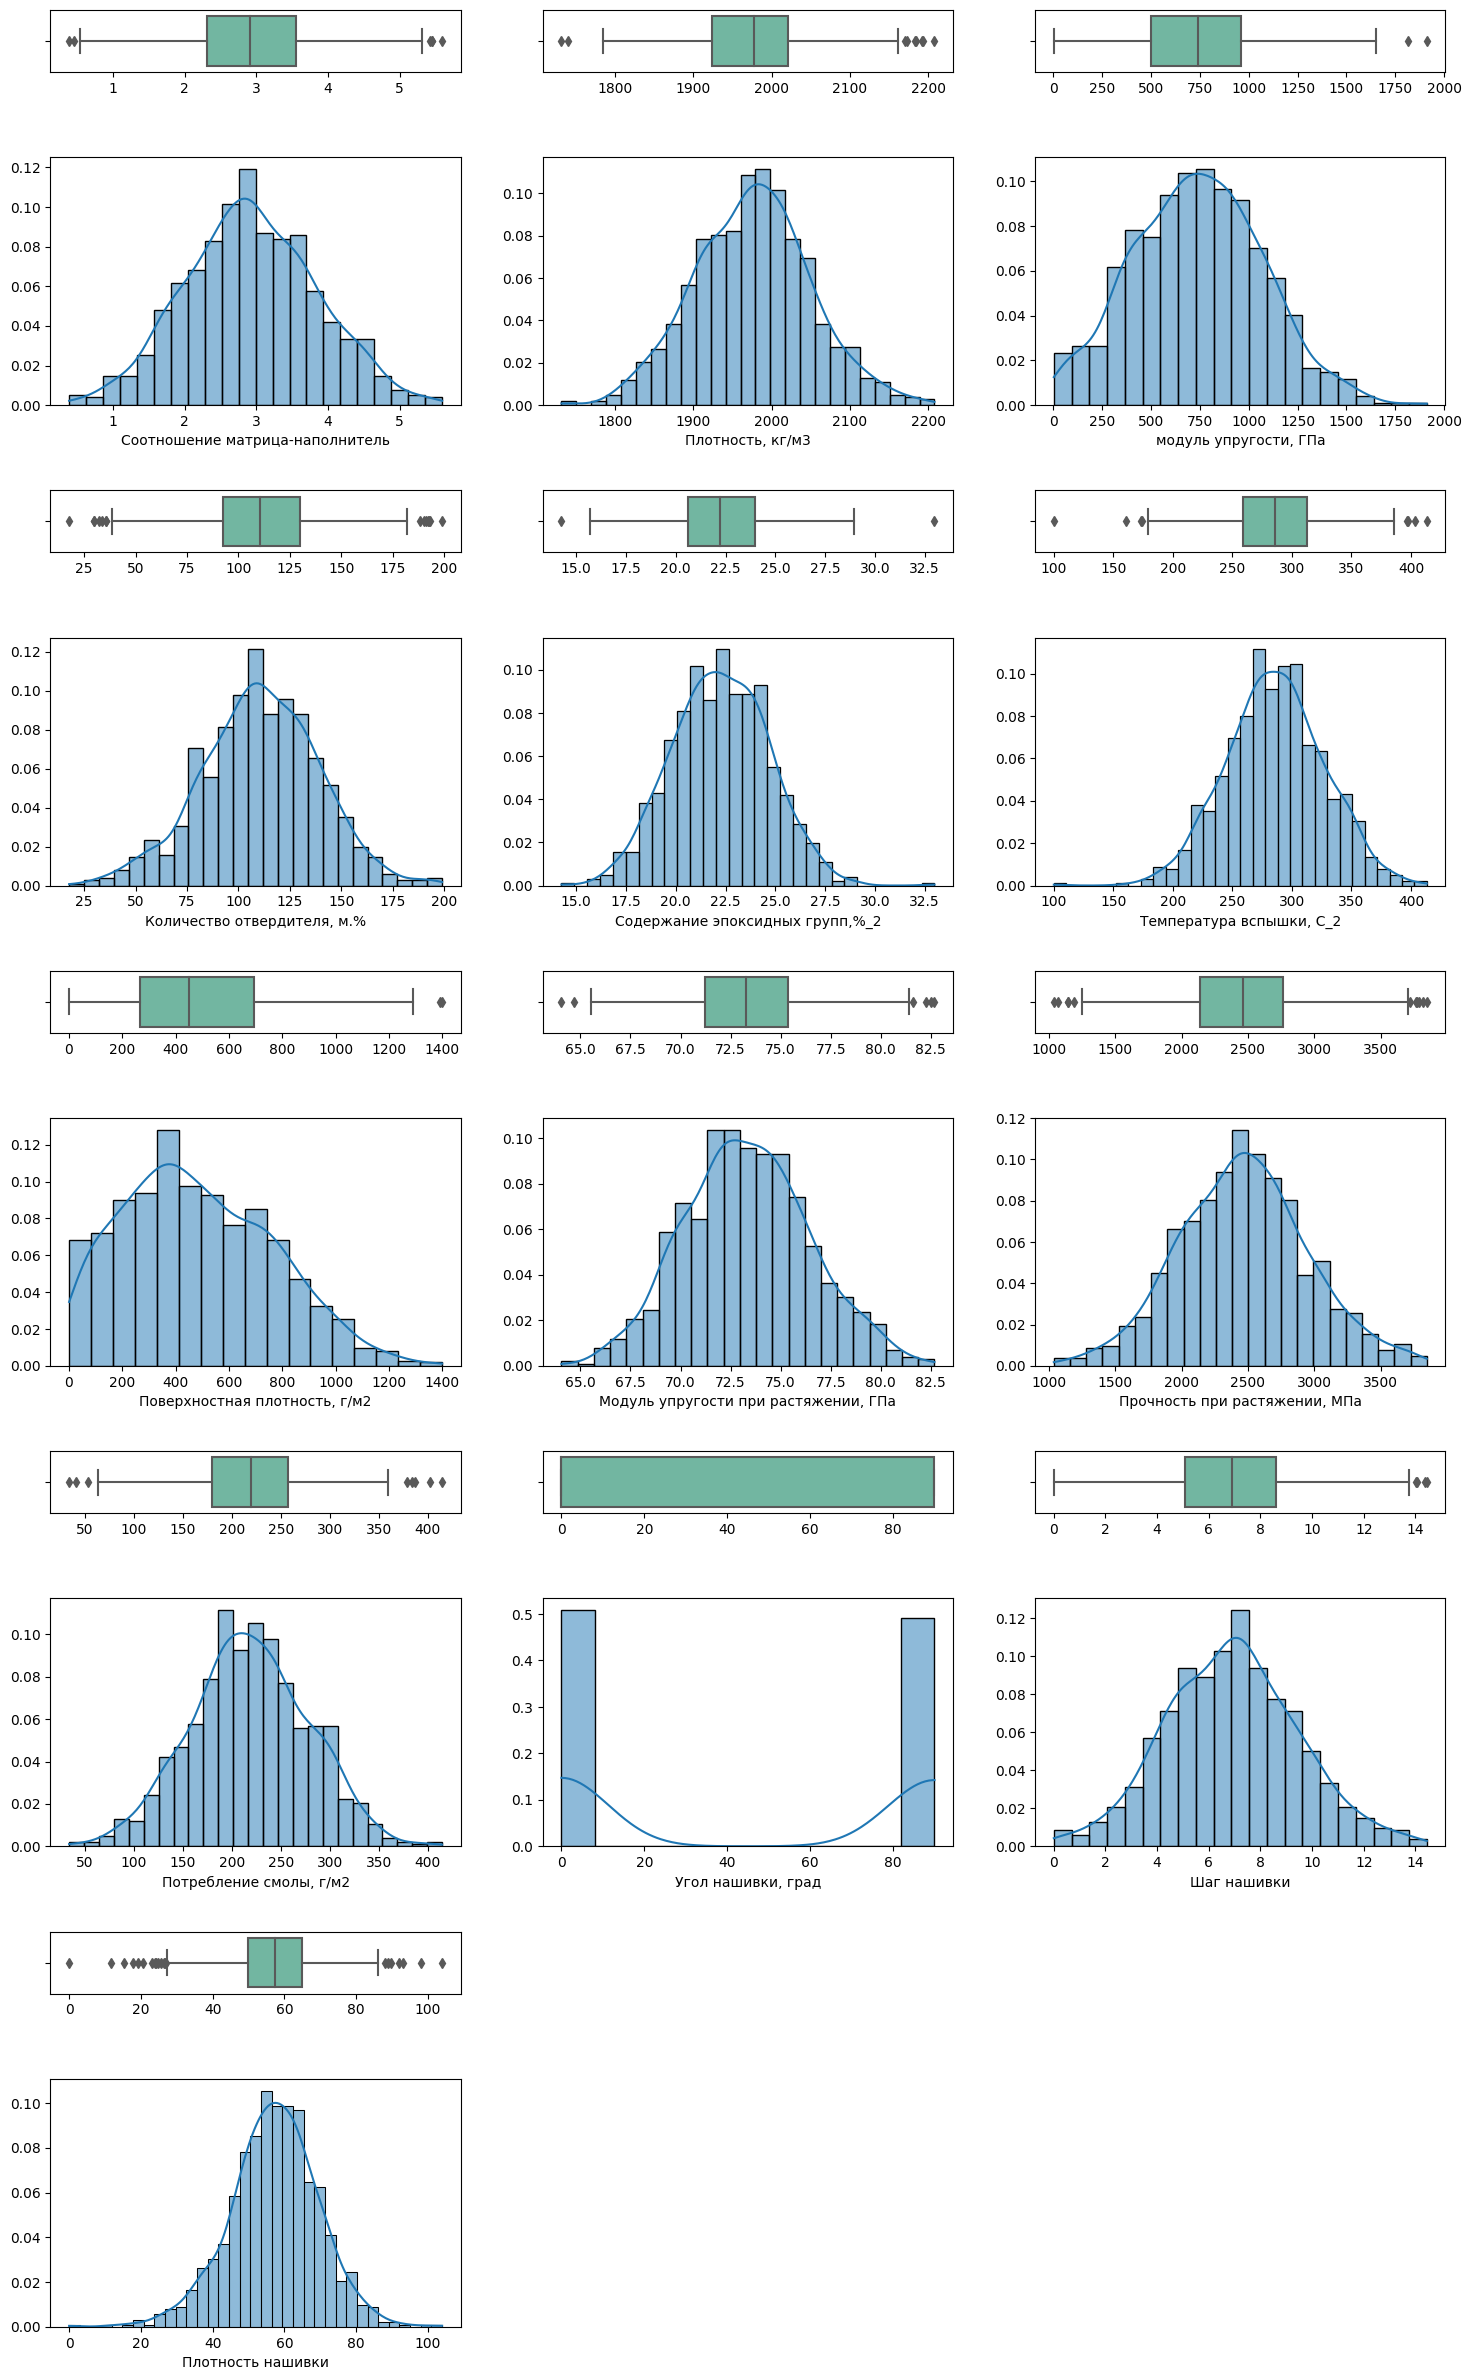

In [13]:
def visual(data, ncols=1):
    if len(data.shape) == 1:
        num_cols = 1
    else:
        num_cols = data.shape[1]
    if ncols > num_cols:
        ncols = num_cols
    spec = mpl.gridspec.GridSpec(ncols=ncols, nrows=num_cols * 2,
                                 height_ratios=[1, 4] * num_cols, hspace=0.55)
    fig = plt.figure(figsize=(18, (num_cols // ncols) * 20))
    i, j = -1, -1
    for l in range(num_cols):
        j += 1
        if not l % ncols:
            j = 0
            i += 1
        ax = fig.add_subplot(spec[2 * ncols * i + j])
        sns.boxplot(data=data, x=data.columns[ncols * i + j],
                    palette='Set2', ax=ax).set(xlabel=None)
        ax = fig.add_subplot(spec[2 * ncols * i + j + ncols])
        sns.histplot(x=data.columns[ncols * i + j], kde=True,
                     ax=ax, data=data, stat='probability').set(ylabel=None)
    plt.show()

visual(full_df, 3)


### Попарные графики рассеяния точек
По-прежнему ничего похожего на линейные зависимости нет. Серьезных выбросов не видно.


In [ ]:
sns.pairplot(full_df)

Output hidden; open in https://colab.research.google.com to view.

### Среднее, медианное значение для каждой колонки

In [14]:
full_df.describe().loc[['mean', '50%']].T

,mean,50%
Соотношение матрица-наполнитель,2.930366,2.906878
"Плотность, кг/м3",1975.734888,1977.621657
"модуль упругости, ГПа",739.923233,739.664328
"Количество отвердителя, м.%",110.570769,110.564840
"Содержание эпоксидных групп,%_2",22.244390,22.230744
"Температура вспышки, С_2",285.882151,285.896812
"Поверхностная плотность, г/м2",482.731833,451.864365
"Модуль упругости при растяжении, ГПа",73.328571,73.268805
"Прочность при растяжении, МПа",2466.922843,2459.524526
"Потребление смолы, г/м2",218.423144,219.198882


In [15]:
full_df.median() / full_df.mean() * 100

Соотношение матрица-наполнитель          99.198458
Плотность, кг/м3                        100.095497
модуль упругости, ГПа                    99.965009
Количество отвердителя, м.%              99.994638
Содержание эпоксидных групп,%_2          99.938655
Температура вспышки, С_2                100.005128
Поверхностная плотность, г/м2            93.605670
Модуль упругости при растяжении, ГПа     99.918495
Прочность при растяжении, МПа            99.700099
Потребление смолы, г/м2                 100.355154
Угол нашивки, град                        0.000000
Шаг нашивки                             100.245271
Плотность нашивки                       100.328919
dtype: float64

Поверхностная плотность, г/м2            93.605670

## Предобработка данных

### При построении модели необходимо 30% данных оставить на тестирование модели, на остальных происходит обучение моделей.

In [36]:
def tt_split(data):
    """
    Разбивает выборку по заданым правилам
    """

    X = data.copy()
    y1 = X.pop('Модуль упругости при растяжении, ГПа')
    y2 = X.pop('Прочность при растяжении, МПа')
    y3 = X.pop('Соотношение матрица-наполнитель')
    
    #y = pd.concat([y1, y2], axis=1)
    #y = y1
    y = y2

    return train_test_split(X, y, test_size = 0.3, random_state = 32)


### Функция для сводной оценки

In [61]:
def est(note, model, data, prt=False, drw=False):
    """
    Разбивает данные, обучает модель.
    Рисует тестовые и предсказанные значения (ожидается прямая y = x)
    Возвращает (и печатает) словарь с примечанием и оценками
    """
    X_train, X_test, y_train, y_test = tt_split(data)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    res = {'note': note,
           'r2': r2_score(y_test, y_pred),
           'MAE': mean_absolute_error(y_test, y_pred),
           'MAPE': np.mean(np.abs((y_test - y_pred)/y_test))*100,
           'params': [model.get_params()]}
    
    # отрисовываем результат приближения нейросетью поверх исходной функции
    if drw:
      plt.scatter(y_test, y_pred, color='black')
      plt.scatter(y_pred, y_pred, color='green')
      plt.scatter(y_test, y_test, color='blue')
      #plt.plot(x, model.predict(x), color='magenta', linewidth=2, antialiased=True)
      plt.show()
      #plt.plot(x, model.predict(x), color='magenta', linewidth=2, antialiased=True)
    if prt:
        for k, v in res.items():
            print(k.rjust(5) + ':', v)
    return pd.DataFrame(res)

### Извлечение корня делает распределение правильнее визуально и дает небольшой прирост в точности
<br>

|          |    до    |  после   |
|----------|----------|----------|
|   r2     | 0.00856  | 0.00906 |
|  MAE     | 402.7968 | 402.6191 |
| MAPE     | 17.79%   | 17.78%   |



### Тестирование на линейном регрессоре

### Оценки до извлечения корня

In [18]:
est('До', LinearRegression(), full_df).drop(['params'], axis=1)

,note,r2,MAE,MAPE
0,До,0.008562,402.796769,17.785224


### Оценки после извлечения корня

In [19]:
w_df = full_df.copy()
w_df['Поверхностная плотность, г/м2'] = np.sqrt(w_df['Поверхностная плотность, г/м2'])

est('После', LinearRegression(), w_df).drop(['params'], axis=1)

,note,r2,MAE,MAPE
0,После,0.009064,402.619146,17.775718


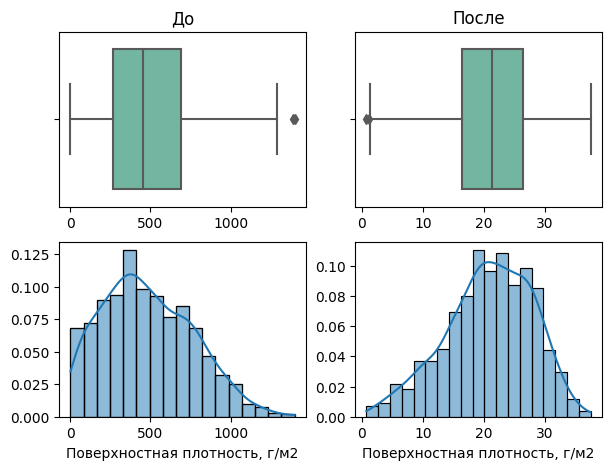

In [20]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(2, 2, 2)
sns.boxplot(data=w_df, x=w_df['Поверхностная плотность, г/м2'],
            palette='Set2', ax=ax).set(xlabel=None, title='После')
ax = fig.add_subplot(2, 2, 4)
sns.histplot(x=w_df['Поверхностная плотность, г/м2'],
             kde=True, ax=ax, data=w_df, stat='probability').set(ylabel=None)
ax = fig.add_subplot(2, 2, 1)
sns.boxplot(data=full_df, x=full_df['Поверхностная плотность, г/м2'],
            palette='Set2', ax=ax).set(xlabel=None, title='До')
ax = fig.add_subplot(2, 2, 3)
sns.histplot(x=full_df['Поверхностная плотность, г/м2'],
             kde=True, ax=ax, data=full_df, stat='probability').set(ylabel=None)
plt.show()

### Функция для исключения выбросов

In [21]:
def ppc(data):
    """ 
    Удаляет выбросы
    """
    #абсолютное значение z-score для каждого наблюдения
    z = np.abs(stats.zscore(data))
    
    #сохраняйте только строки в кадре данных смодулем z-оценками меньше 3
    return data[(z<3).all(axis=1)]

### Попробую без выбросов

In [22]:
est('-выбросы', LinearRegression(), ppc(w_df)).drop('params', axis=1)

,note,r2,MAE,MAPE
0,-выбросы,0.024465,371.494344,16.57817


без выбросов r2 лучше. Удаляю

In [23]:
w_df = ppc(w_df)

## Обучить нескольких моделей для прогноза модуля упругости при растяжении и прочности при растяжении.

In [24]:
w_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,1001.0,2.938832,0.908753,0.389403,2.322801,2.913953,3.557018,5.591742
"Плотность, кг/м3",1001.0,1975.506670,72.902107,1784.482245,1923.762595,1977.562320,2021.145909,2192.738783
"модуль упругости, ГПа",1001.0,738.013623,327.515848,2.436909,498.596429,739.664328,957.395628,1649.415706
"Количество отвердителя, м.%",1001.0,110.857999,27.811487,29.956150,92.618011,110.689775,129.821713,192.851702
"Содержание эпоксидных групп,%_2",1001.0,22.234355,2.382712,15.695894,20.583309,22.220097,23.972972,28.955094
"Температура вспышки, С_2",1001.0,285.886112,40.278840,173.484920,258.991905,285.811108,313.023467,403.652861
"Поверхностная плотность, г/м2",1001.0,20.785506,7.027353,0.777007,16.344443,21.244053,26.311045,37.410458
"Модуль упругости при растяжении, ГПа",1001.0,73.309021,3.098147,64.054061,71.252628,73.219286,75.321098,82.525773
"Прочность при растяжении, МПа",1001.0,2467.206874,484.973221,1036.856605,2135.779172,2459.524526,2761.393722,3848.436732
"Потребление смолы, г/м2",1001.0,218.311939,58.945161,41.048278,179.858423,218.946348,257.495622,386.903431


### Обучение пяти моделей

In [32]:
w_df = w_df.drop(drop_cols, axis=1)

In [33]:
#  Линейная регрессия
lr = LinearRegression()

#  Метод опорных векторов
svr = make_pipeline(StandardScaler(), SVR())

#  Случайный лес
rf = RandomForestRegressor()

#  Градиентный бустинг
gbr = make_pipeline(StandardScaler(), GradientBoostingRegressor())

#  Лассо регрессор
lsr = Lasso()

### Функция для бучения и оценки

In [34]:
def mls(note, data):
    """
    Возвращает таблицу с результатами обучения
    """
      
    # Линейная регрессия
    df = est('lr' + note, lr, data)


    # Метод опорных векторов
    # 'C': 1.0,
    # 'epsilon': 0.1,
    df = pd.concat([df, est('svr' + note, svr, data, drw=True)],
                   axis=0, ignore_index=True)


    # Случайный лес
    df = pd.concat([df, est('rf' + note, rf, data, drw=True)],
                   axis=0, ignore_index=True)


    # Градиентный бустинг
    df = pd.concat([df, est('gbr' + note, gbr, data, drw=True)],
                   axis=0, ignore_index=True)


    # Лассо регрессор
    df = pd.concat([df, est('lsr' + note, lsr, data, drw=True)],
                   axis=0, ignore_index=True)
    
    return df

### Добавим оценки в сводную таблицу

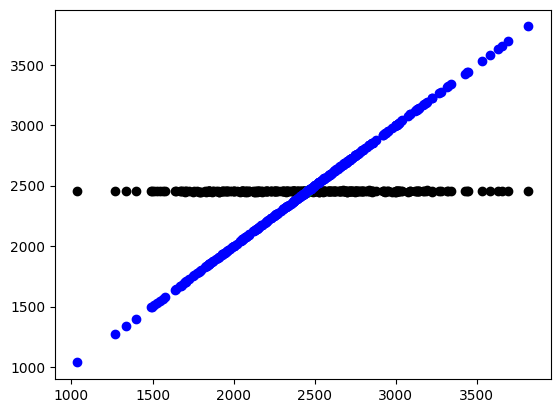

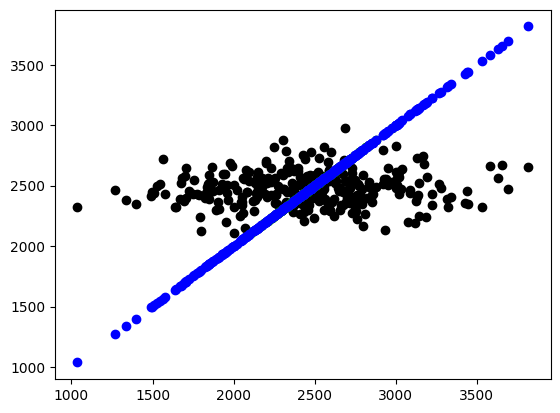

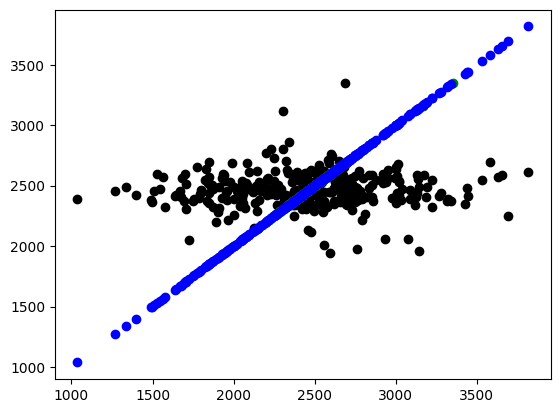

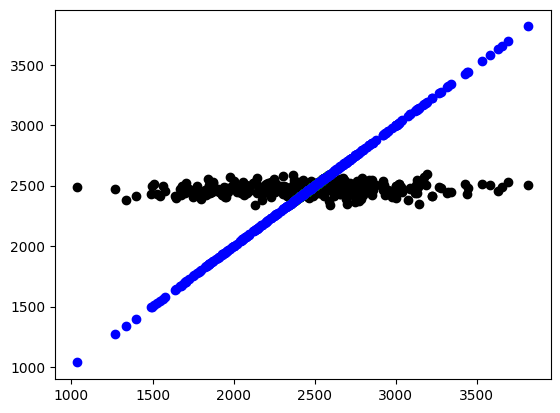

In [63]:
est_df = mls('', w_df) # обучение 5 моделей результаты в est_df

In [62]:
print(est_df.drop(['params'], axis=1).sort_values(by='r2', ascending=False))

  note        r2         MAE       MAPE
0   lr  0.009135  373.991501  16.705324
4  lsr  0.009088  373.958140  16.704706
1  svr  0.000610  375.228270  16.669879
2   rf -0.066008  398.866294  17.693864
3  gbr -0.084252  396.856286  17.573285


### При построении моделей провести поиск гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10.

In [23]:
def scattgird(data, ncols=4):
    """
    Рисует серию точечных графиков
    """
    l = data.shape[1] - 2
    if ncols <1: ncols = 1
    if l < 1: l = 1
    nrows = int(np.ceil(l / ncols))

    fig = plt.figure(figsize=(3 * ncols, 4 * nrows))
    f = 'mean_test_score'

    for c in range(1, l + 1):
        if not (c - 1) % ncols:
            f = 'mean_test_score'
        sns.set(font_scale = 2/3)
        ax = fig.add_subplot(nrows, ncols, c)
        sns.scatterplot(data=data, ax=ax , legend=False,
                        x=data.columns[c - 1],
                        y='mean_test_score', 
                        hue='rank_test_score').set(ylabel=f)
        f = None
    plt.show()

In [24]:
def rs_viz(note, model, data, param_distr, ncols=3):
    """
    Визуализация случайного поиска гиперпараметров
     
    """

    rs = RandomizedSearchCV(
        model, n_iter = 33, cv = 10, verbose = 1, n_jobs=-1,
        random_state=32, scoring='r2',
        param_distributions=param_distr
        )

    X_train, X_test, y_train, y_test = tt_split(w_df)

    rs.fit(X_train, y_train)
    
    ls = ['param_' + i for i in param_distr]
    ls.append('rank_test_score')
    ls.append('mean_test_score')

    # дата фрейм с результатами случайного поиска гиперпараметров
    rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score')
    rs_df = rs_df[ls]
    rs_df.reset_index(drop=True)
    rs_df['mean_test_score'] = -rs_df['mean_test_score']
            
    # визуализация 'split2_test_score',
    scattgird(rs_df, ncols)
    
    return pd.DataFrame(est('RS-' + note, rs.best_estimator_, data)), rs_df

    

### RandomForestRegressor
* n_estimators — число «деревьев» в «случайном лесу».
* max_features — число признаков для выбора расщепления.
* max_depth — максимальная глубина деревьев.
* min_samples_split — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться.
* min_samples_leaf — минимальное число объектов в листьях.
* bootstrap — использование для построения деревьев подвыборки с возвращением.


In [25]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Fitting 10 folds for each of 33 candidates, totalling 330 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 330.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils/_pa

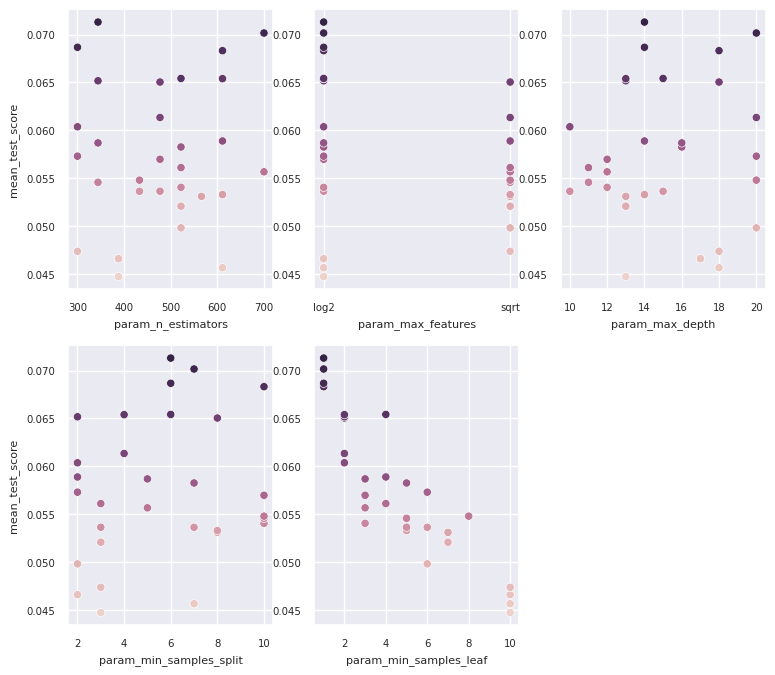

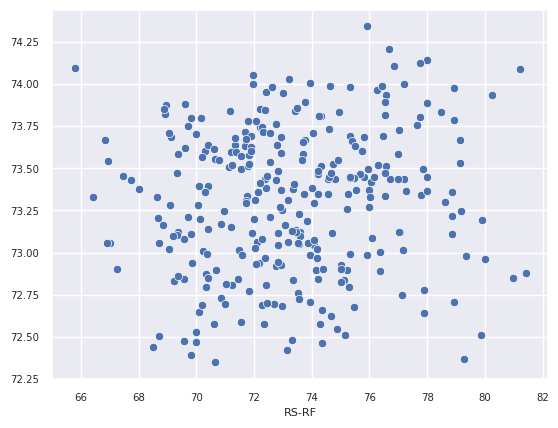

    note        r2       MAE      MAPE
4    lsr  0.013006  2.450698  3.340452
0     lr  0.010789  2.447343  3.335593
5  RS-RF  0.009145  2.458649  3.351736
2     rf -0.009742  2.465076  3.361956
1    svr -0.020052  2.492573  3.398132
3    gbr -0.052000  2.566901  3.503828

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 13, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 388, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [61]:
tmp = rs_viz('RF', RandomForestRegressor(), w_df, {
    'n_estimators': [int(x) for x in np.linspace(start = 300, 
                                                 stop = 700,
                                                 num = 10)],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(start = 10,
                                              stop = 20,
                                              num = 15)],
    'min_samples_split': [int(x) for x in np.linspace(start = 1,
                                                      stop = 10,
                                                      num = 9)],
    'min_samples_leaf': [int(x) for x in np.linspace(start = 1,
                                                     stop = 10,
                                                     num = 9)]
    })

est_df = pd.concat([est_df, tmp[0]], ignore_index=True)
print(est_df.drop(['params'], axis=1).sort_values(by='r2', ascending=False))
print()
print(*tmp[0]['params'])

In [ ]:
GSCV = GridSearchCV(RandomForestRegressor(), {
    'n_estimators': [300, 350, 522],
    'max_features': ['log2', 'sqrt', 1.0, 2.0],
    'max_depth': [11, 10, 12],
    'min_samples_split': [2, 3, 1],
    'min_samples_leaf': [3, 4, 5],
    'bootstrap': [True]
    },
    cv=2, scoring='r2')

X_train, X_test, y_train, y_test = tt_split(w_df)
GSCV.fit(X_train, y_train)
print(GSCV.best_estimator_ )
print()
est_df = pd.concat([est_df,
                    est('GS-RF',GSCV.best_estimator_, w_df)],
                   ignore_index=True)
est_df.drop('params', axis=1).sort_values(by='r2', ascending=False)


c:\Users\RT\anaconda3\envs\BKP\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\RT\anaconda3\envs\BKP\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RT\anaconda3\envs\BKP\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "c:\Users\RT\anaconda3\envs\BKP\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\RT\anaconda3\envs\BKP\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\RT\anaconda3\envs\BKP\lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callb

RandomForestRegressor(max_depth=10, max_features='log2', min_samples_leaf=4,
                      n_estimators=350)



,note,r2,MAE,MAPE
4,lsr,0.024670,371.433592,16.576802
0,lr,0.024465,371.494344,16.578170
5,RS-RF,0.002565,378.722346,16.906860
6,GS-RF,0.002353,378.597879,16.900832
1,svr,0.000878,375.125760,16.671367
2,rf,-0.035134,389.514700,17.350702
3,gbr,-0.039949,390.049335,17.298354


### SVR
* kernel {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’ Указывает тип ядра, который будет использоваться в алгоритме. Он должен быть одним из «линейных», «полигональных», «rbf», «сигмоидальных», «предварительно вычисленных» или вызываемых.

* degree int, default=3 Степень полиномиальной функции ядра («поли»). Игнорируется всеми другими ядрами.

* gamma {‘scale’, ‘auto’} or float, default=’scale’ Коэффициент ядра для «rbf», «poly» и «sigmoid». Eсли передается gamma='scale' (по умолчанию), то в качестве значения гаммы используется 1 / (n_features * X.var ()), если «авто», использует 1 / n_features.

* coef0 float, default=0.0 Независимый член в функции ядра. Это имеет значение только в «поли» и «сигмовидной».

* tol float, default=1e-3 Толерантность к критерию остановки.

* C float, default=1.0 Параметр регуляризации. Сила регуляризации обратно пропорциональна C. Должна быть строго положительной. Штраф представляет собой квадратичный штраф l2.

* epsilon float, default=0.1 Эпсилон в модели Эпсилон-СВР. Он определяет эпсилон-трубку, в пределах которой нет штрафных санкций в функции потери тренировки с очками, предсказанными на расстоянии эпсилон от фактического значения.

* shrinking bool, default=True Использовать ли эвристику сжатия.

* cache_size float, default=200 размер кэша ядра (в мегабайтах).

* verbose bool, default=False Включить многословный вывод.Обратите внимание,что эта настройка использует преимущества настройки времени выполнения каждого процесса в libsvm,которая,если она включена,может работать некорректно в многопоточном контексте.

* max_iter int, default=-1 Жесткий лимит на итерации внутри решателя,или -1 без ограничения.

In [ ]:
SVR().get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Fitting 10 folds for each of 33 candidates, totalling 330 fits


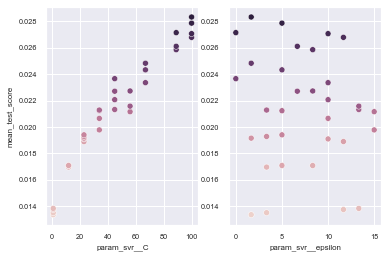

     note        r2         MAE       MAPE
4     lsr  0.024670  371.433592  16.576802
0      lr  0.024465  371.494344  16.578170
5   RS-RF  0.002565  378.722346  16.906860
6   GS-RF  0.002353  378.597879  16.900832
1     svr  0.000878  375.125760  16.671367
7  RS-SVR  0.000845  375.163703  16.667299
2      rf -0.035134  389.514700  17.350702
3     gbr -0.039949  390.049335  17.298354

{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('svr', SVR(epsilon=1.6676))], 'verbose': False, 'standardscaler': StandardScaler(), 'svr': SVR(epsilon=1.6676), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'svr__C': 1.0, 'svr__cache_size': 200, 'svr__coef0': 0.0, 'svr__degree': 3, 'svr__epsilon': 1.6676, 'svr__gamma': 'scale', 'svr__kernel': 'rbf', 'svr__max_iter': -1, 'svr__shrinking': True, 'svr__tol': 0.001, 'svr__verbose': False}


In [ ]:
tmp = rs_viz('SVR', make_pipeline(StandardScaler(), SVR()), w_df, {
    'svr__C': [round(x, 3) for x in np.linspace(start = 1,
                                                stop = 100,
                                                num = 10)],
    'svr__epsilon': [round(x, 4) for x in np.linspace(start = 0.001,
                                                      stop = 15,
                                                      num = 10)],
    #'svr__kernel': ['rbf'],
    #'svr__gamma': ['scale']
    #[round(x, 3) for x in np.linspace(start = 0.001, stop = 0.999, num = 5)]
    },
    ncols=2)

est_df = pd.concat([est_df, tmp[0]], ignore_index=True)
print(est_df.drop(['params'], axis=1).sort_values(by='r2', ascending=False))
print()
print(*tmp[0]['params'])

In [ ]:
GSCV = GridSearchCV(make_pipeline(StandardScaler(), SVR()), {
    'svr__C': [1, 2],
    'svr__epsilon': [1, 2, 3]
    },
    cv=10, scoring='r2')

X_train, X_test, y_train, y_test = tt_split(w_df)
GSCV.fit(X_train, y_train)
print(GSCV.best_estimator_ )
print()
est_df = pd.concat([est_df,
                    pd.DataFrame(est('GS-SVR',
                    GSCV.best_estimator_, w_df))],
                   ignore_index=True)
est_df.drop('params', axis=1).sort_values(by='r2', ascending=False)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=1, epsilon=1))])



,note,r2,MAE,MAPE
4,lsr,0.024670,371.433592,16.576802
0,lr,0.024465,371.494344,16.578170
5,RS-RF,0.002565,378.722346,16.906860
6,GS-RF,0.002353,378.597879,16.900832
1,svr,0.000878,375.125760,16.671367
8,GS-SVR,0.000851,375.141342,16.669606
7,RS-SVR,0.000845,375.163703,16.667299
2,rf,-0.035134,389.514700,17.350702
3,gbr,-0.039949,390.049335,17.298354


##  GradientBoostingRegressor
* learning_rate : float, optional (default=0.1) ключевой для настройки параметр
* n_estimators: int (default=100) Количество «boosting stages» при обучении модели градиентного бустинга
* max_depth: integer, optional (default=3) Максимальная глубина отдельных регрессионных оценок. Максимальная глубина ограничивает количество узлов в дереве.
* criterion: string, optional (default=«friedman_mse») Функция измерения качества разделения. Поддерживаемые критерии: «friedman_mse» для среднеквадратичной ошибки с оценкой улучшения по Фридману, «mse» для среднеквадратичной ошибки и «mae» для средней абсолютной ошибки. Значение по умолчанию «friedman_mse», как правило, является лучшим, поскольку в некоторых случаях оно может обеспечить лучшее приближение.
* min_samples_split: int, float, optional (default=2) Минимальное количество примеров, необходимое для продолжения достраивания дерева в данной вершине при обучении. Попробуем изменить его.
* min_samples_leaf: int, float, optional (default=1) Минимальное количество примеров, которое может находиться в листе дерева после обучения. Увеличение этого параметра снижает качество предсказания на тренировочной выборке (т. к. при меньшем значении деревья, составляющие ансамбль в большей степени подстраиваются под каждый конкретный пример из обучающей выборки) и, если повезет, повышает качество на валидационной. То есть, по крайней мере теоретически, помогает бороться с переобучением.
* min_weight_fraction_leaf: float, optional (default=0.) Минимальная часть примеров, необходимая для формирования листа. По умолчанию их количество равно нулю, то есть не задает никакого ограничения. По идее, увеличение значения этого параметра должно препятствовать переобучению, подобно параметру mean_samples_leaf.

In [ ]:
gbr = make_pipeline(StandardScaler(), GradientBoostingRegressor())

In [ ]:
GradientBoostingRegressor().get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

  'gradientboostingregressor__learning_rate': 0.55,
  'gradientboostingregressor__n_estimators': 100,
  'gradientboostingregressor__max_depth': 3,
  'gradientboostingregressor__min_samples_split': 4
  'gradientboostingregressor__min_samples_leaf': 5 ,
  'gradientboostingregressor__random_seed': 0

Fitting 10 folds for each of 33 candidates, totalling 330 fits


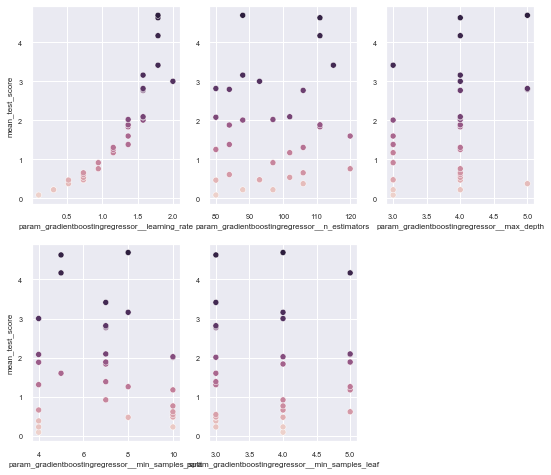

     note        r2         MAE       MAPE
4     lsr  0.024670  371.433592  16.576802
0      lr  0.024465  371.494344  16.578170
5   RS-RF  0.002565  378.722346  16.906860
6   GS-RF  0.002353  378.597879  16.900832
1     svr  0.000878  375.125760  16.671367
8  GS-SVR  0.000851  375.141342  16.669606
7  RS-SVR  0.000845  375.163703  16.667299
9  RS-GBR -0.034121  388.472834  17.174696
2      rf -0.035134  389.514700  17.350702
3     gbr -0.039949  390.049335  17.298354

{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('gradientboostingregressor', GradientBoostingRegressor(min_samples_leaf=4, min_samples_split=4,
                          n_estimators=80))], 'verbose': False, 'standardscaler': StandardScaler(), 'gradientboostingregressor': GradientBoostingRegressor(min_samples_leaf=4, min_samples_split=4,
                          n_estimators=80), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'gradientboostingregresso

In [ ]:
tmp = rs_viz('GBR', make_pipeline(StandardScaler(),
                                    GradientBoostingRegressor()), w_df,
    {
    'gradientboostingregressor__learning_rate': [
        round(x, 4) for x in np.linspace(start = 0.1, stop = 2, num = 10)],
    'gradientboostingregressor__n_estimators': [
        int(x) for x in np.linspace(start = 80, stop = 120, num = 10)],
    'gradientboostingregressor__max_depth': [
        int(x) for x in np.linspace(start = 3, stop = 5, num = 5)],
    'gradientboostingregressor__min_samples_split': [
        int(x) for x in np.linspace(start = 4, stop = 10, num = 5)],
    'gradientboostingregressor__min_samples_leaf': [
        int(x) for x in np.linspace(start = 3, stop = 5, num = 5)],
    },
    ncols=3)

est_df = pd.concat([est_df, tmp[0]], ignore_index=True)
print(est_df.drop(['params'], axis=1).sort_values(by='r2', ascending=False))
print()
print(*tmp[0]['params'])

### подбор по сетке

In [ ]:
GSCV = GridSearchCV(make_pipeline(StandardScaler(),
                                    GradientBoostingRegressor()), {
    'gradientboostingregressor__learning_rate': [0.01, 0.05, 0.1],
    'gradientboostingregressor__n_estimators': [60, 70, 80],
    'gradientboostingregressor__max_depth': [2, 3, 4],
    'gradientboostingregressor__min_samples_split': [4, 8, 10],
    'gradientboostingregressor__min_samples_leaf': [2, 3, 4],
    },
    cv=10, scoring='r2')

X_train, X_test, y_train, y_test = tt_split(w_df)
GSCV.fit(X_train, y_train)

print(GSCV.best_estimator_ )
print()
est_df = pd.concat([est_df,
                    pd.DataFrame(est('GS-GBR',
                    GSCV.best_estimator_, w_df))],
                   ignore_index=True)
est_df.drop('params', axis=1).sort_values(by='r2', ascending=False)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=2,
                                           min_samples_leaf=2,
                                           min_samples_split=8,
                                           n_estimators=60))])



,note,r2,MAE,MAPE
4,lsr,0.024670,371.433592,16.576802
0,lr,0.024465,371.494344,16.578170
10,GS-GBR,0.005361,375.055875,16.778653
5,RS-RF,0.002565,378.722346,16.906860
6,GS-RF,0.002353,378.597879,16.900832
1,svr,0.000878,375.125760,16.671367
8,GS-SVR,0.000851,375.141342,16.669606
7,RS-SVR,0.000845,375.163703,16.667299
9,RS-GBR,-0.034121,388.472834,17.174696
2,rf,-0.035134,389.514700,17.350702


## Lasso


In [ ]:
Lasso().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

Fitting 10 folds for each of 33 candidates, totalling 330 fits


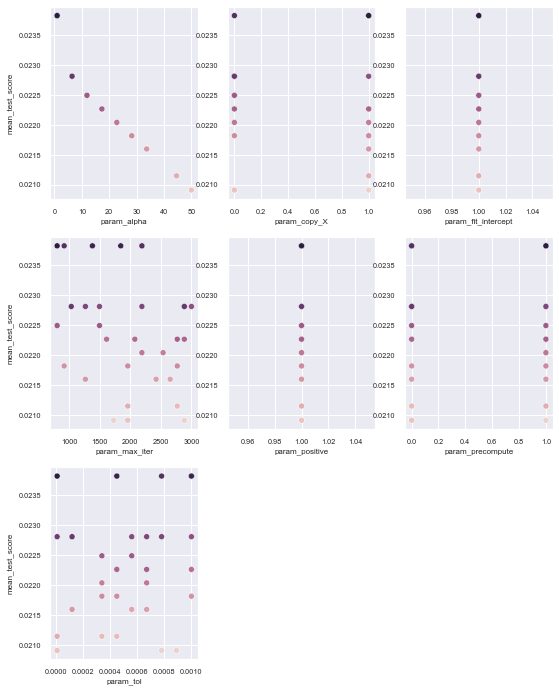

        note        r2         MAE       MAPE
4        lsr  0.024670  371.433592  16.576802
0         lr  0.024465  371.494344  16.578170
10    GS-GBR  0.005361  375.055875  16.778653
5      RS-RF  0.002565  378.722346  16.906860
6      GS-RF  0.002353  378.597879  16.900832
11  RS-Lasso  0.001517  373.839845  16.725076
1        svr  0.000878  375.125760  16.671367
8     GS-SVR  0.000851  375.141342  16.669606
7     RS-SVR  0.000845  375.163703  16.667299
9     RS-GBR -0.034121  388.472834  17.174696
2         rf -0.035134  389.514700  17.350702
3        gbr -0.039949  390.049335  17.298354

{'alpha': 50.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 2884, 'normalize': False, 'positive': True, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0008900000000000001, 'warm_start': False}


In [ ]:
tmp = rs_viz('Lasso', Lasso(), w_df,
    {
    'alpha': [
        round(x, 4) for x in np.linspace(start = 1, stop = 50, num = 10)],
    'copy_X': [
        True, False],       
    'fit_intercept': [
        True],
    'max_iter': [
        int(x) for x in np.linspace(start = 800, stop = 3000, num = 20)],
    'positive': [
        True],
     'precompute': [
         True, False
     ],
     'tol': [
        float(x) for x in np.linspace(start = 0.001, stop = 0.00001, num = 10)]
    },
    ncols=3)

est_df = pd.concat([est_df, tmp[0]], ignore_index=True)
print(est_df.drop(['params'], axis=1).sort_values(by='r2', ascending=False))
print()
print(*tmp[0]['params'])

Lasso(alpha=55, max_iter=2000, positive=True, tol=0.0004)



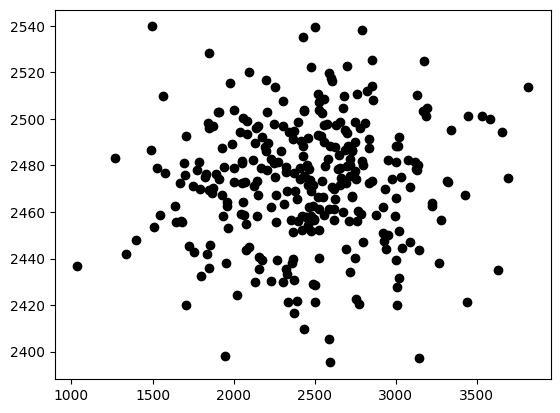

,note,r2,MAE,MAPE
4,lsr,0.024670,371.433592,16.576802
0,lr,0.024465,371.494344,16.578170
5,GS-Lasso,0.001495,373.866999,16.726443
1,svr,0.000878,375.125760,16.671367
2,rf,-0.019490,386.417580,17.268903
3,gbr,-0.039967,390.691208,17.320234


In [45]:
GSCV = GridSearchCV(Lasso(), {
    'alpha': [45, 50, 55],
    'max_iter': [2000, 3000, 4000],
    'positive': [ True, False],
    'tol': [0.0004, 0.0009, 0.001]
    },
    cv=10, scoring='r2')

X_train, X_test, y_train, y_test = tt_split(w_df)
GSCV.fit(X_train, y_train)
print(GSCV.best_estimator_ )
print()
est_df = pd.concat([est_df,
                    pd.DataFrame(est('GS-Lasso',
                    GSCV.best_estimator_, w_df))],
                   ignore_index=True)
est_df.drop('params', axis=1).sort_values(by='r2', ascending=False)

In [170]:
pd.DataFrame(est('GS-Lasso', GSCV.best_estimator_, w_df))

,note,r2,MAE,MAPE,params
0,GS-Lasso,0.001495,373.866999,16.726443,"{'alpha': 55, 'copy_X': True, 'fit_intercept':..."


## Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель.

model.add(Dense(1,
                activation='linear',
                bias_initializer='glorot_normal',
                kernel_initializer='glorot_normal'))

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

In [45]:
import tensorflow as tf
from keras.models import Sequential # слоистая сеть
from keras.layers import Dense, Dropout #  слой
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

In [3]:
stsc = MinMaxScaler()

In [39]:
X_train, X_test, y_train, y_test = tt_split(w_df)


In [ ]:
y_train

In [40]:
X_train = stsc.fit_transform(np.array(X_train))


In [41]:
X_test = stsc.fit_transform(np.array(X_test))


In [42]:
y_train = stsc.fit_transform(np.array(y_train).reshape(-1, 1))


In [43]:
y_test = stsc.fit_transform(np.array(y_test).reshape(-1, 1))

In [46]:
model = Sequential()
# Добавим к модели полносвязный слой с 8 узлами:
model.add(Dense(8, activation='linear', input_dim=X_train.shape[1]))
# Добавим другой слой:
model.add(Dense(8, activation='linear'))
# Добавим выходной слой linear:
model.add(Dense(y_train.shape[1], activation='linear'))

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)


In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = model.fit(X_train, y_train, epochs=40, verbose = 1)

Epoch 1/40
22/22 [==============================] - 1s 2ms/step - loss: 0.2434
Epoch 2/40
22/22 [==============================] - 0s 2ms/step - loss: 0.0372
Epoch 3/40
22/22 [==============================] - 0s 2ms/step - loss: 0.0338
Epoch 4/40
22/22 [==============================] - 0s 2ms/step - loss: 0.0327
Epoch 5/40
22/22 [==============================] - 0s 2ms/step - loss: 0.0325
Epoch 6/40
22/22 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 7/40
22/22 [==============================] - 0s 1ms/step - loss: 0.0318
Epoch 8/40
22/22 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 9/40
22/22 [==============================] - 0s 2ms/step - loss: 0.0315
Epoch 10/40
22/22 [==============================] - 0s 2ms/step - loss: 0.0316
Epoch 11/40
22/22 [==============================] - 0s 2ms/step - loss: 0.0318
Epoch 12/40
22/22 [==============================] - 0s 1ms/step - loss: 0.0320
Epoch 13/40
22/22 [==============================

In [50]:
y_pred = model.predict(X_test)

10/10 [==============================] - 0s 2ms/step


In [ ]:
stsc.inverse_transform(y_train)

In [52]:
r2_score(y_test, y_pred)

0.00887844128635129

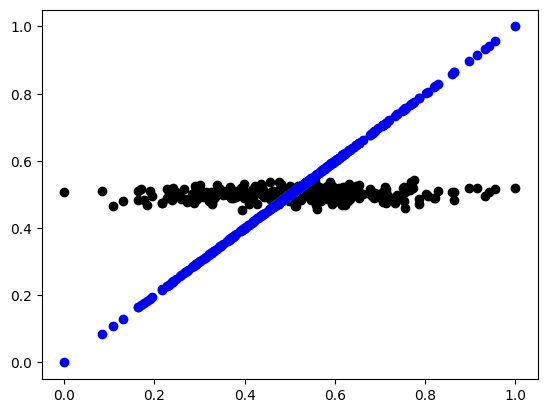

In [60]:
# отрисовываем результат приближения нейросетью поверх исходной функции
plt.scatter(y_test, y_pred, color='black')
plt.scatter(y_pred, y_pred, color='green')
plt.scatter(y_test, y_test, color='blue')
#plt.plot(x, model.predict(x), color='magenta', linewidth=2, antialiased=True)
plt.show()


<Axes: >

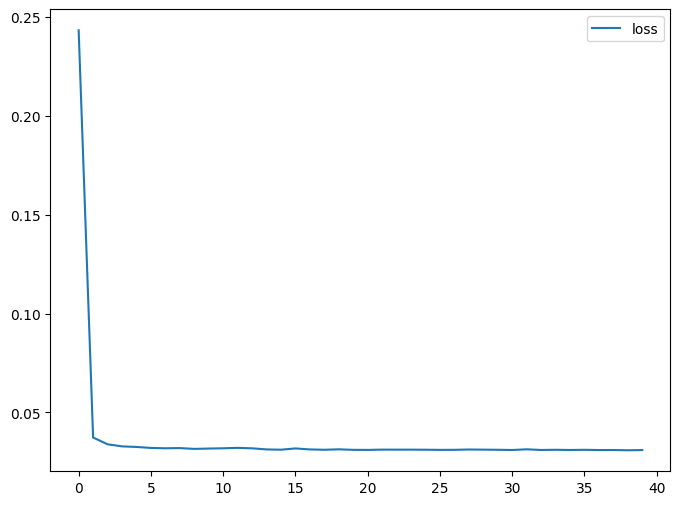

In [54]:
pd.DataFrame(history.history).plot(figsize=(8,6)) # метрики и функции потерь

In [241]:
est_df = pd.concat([est_df,
                    pd.DataFrame(est('NN 20 20',
                    model, w_df))],
                   ignore_index=True)
print(est_df.drop(['params'], axis=1).sort_values(by='r2', ascending=False))
print()
print(*tmp[0]['params'])

10/10 [==============================] - 0s 2ms/step


ValueError: ignored

In [ ]:
y_test